In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from torch.autograd import Variable
from unet import UNet
from early_stopping import EarlyStopping 

In [2]:
dir_path ="train/clean"

In [3]:
def padding_left(numpy_image, frame_size):
    result_image = np.zeros((frame_size,numpy_image.shape[1])).astype(np.float16)
    result_image[:numpy_image.shape[0],:] =numpy_image
    return result_image    

In [4]:
def normalize_data(numpy_array):
        numpy_array =(numpy_array -numpy_array.min())/ (numpy_array.max()- numpy_array.min()) *255
        return numpy_array.astype(np.uint8)

In [5]:
def cut_image_into_frames(numpy_image, frame_size):
    if (numpy_image.shape[0]< frame_size):
        result_image =padding_left(numpy_image, frame_size)
        return [result_image]
    elif(numpy_image.shape[0]== frame_size):
        return [numpy_image]
    else:
        results =[]
        frame_number =int(np.ceil(numpy_image.shape[0]/frame_size))
        for frame_id in range(0,frame_number):
            if(numpy_image.shape[0]>=(frame_id+1)*frame_size):
                result_image=numpy_image[frame_id*frame_size:(frame_id+1)*frame_size, :]
                results.append(result_image)
            else:
                result_image=padding_left(numpy_image[frame_id*frame_size:, :],frame_size)
                results.append(result_image)
        return results       

In [6]:
def combine_frames(results, size):
    result_frame =np.concatenate(results, axis=0)
    return result_frame[:size, :]

In [7]:
class DenoisingDatasetVal(Dataset):    
    """Sound denoising dataset."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        clean_path ="clean"
        noisy_path ="noisy"
        self.train_mels =[]
        train_packages =os.listdir(os.path.join(self.root_dir, clean_path))
        for train_package in train_packages:
            clean_package =os.path.join(self.root_dir,clean_path,train_package)
            mel_files =os.listdir(clean_package)
            for mel_file in mel_files:
                mel_clean =os.path.join(clean_package,mel_file)
                mel_noise =os.path.join(self.root_dir,noisy_path,train_package, mel_file)
                self.train_mels.append((mel_clean,mel_noise))

    def __len__(self):
        return len(self.train_mels)

    def __getitem__(self, idx):
        path_clean =self.train_mels[idx][0]
        path_noise =self.train_mels[idx][1]
        return path_clean, path_noise

In [8]:
class DenoisingDatasetTrain(Dataset):    
    """Sound denoising dataset."""

    def __init__(self, train_path):
        self.train_path = train_path
        self.data =pd.read_csv(self.train_path)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        path_clean =self.data.iloc[idx]["mel_clean_frame_path"]
        path_noise =self.data.iloc[idx]["mel_noise_frame_path"]
        study_id= self.data.iloc[idx]["study_id"]
        clean_image_frame =np.load(path_clean)
        noisy_image_frame =np.load(path_noise)
        clean_image_frame =clean_image_frame[np.newaxis, :, :]
        noisy_image_frame =noisy_image_frame[np.newaxis, :, :]
        return study_id,clean_image_frame, noisy_image_frame

In [9]:
def plot_frames(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(normalize_data(args[i][j]))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [10]:
def plot_validation_frames(mel_clean,mel_noise,output_clean):
    mel_clean =normalize_data(mel_clean)
    mel_noise =normalize_data(mel_noise)
    output_clean =normalize_data(output_clean)
    print(mel_clean.shape, mel_noise.shape,output_clean.shape)
    print("Ml-спектограмма без шума:")
    plt.imshow(mel_clean.T)
    plt.show()
    print("Зашумленная Ml-спектограмма:")
    plt.imshow(mel_noise.T)
    plt.show()
    print("Очищенная Ml-спектограмма:")
    plt.imshow(output_clean.T)
    plt.show()

In [11]:
train_data=DenoisingDatasetTrain("denoising_dataset.csv")
val_data=DenoisingDatasetVal("val")

In [12]:
train_loader =DataLoader(train_data, batch_size=64, shuffle=True)
val_loader =DataLoader(val_data, batch_size=1, shuffle=True)

In [13]:
num_epochs =50
learning_rate =0.001
frame_size= 80
early_stopping =EarlyStopping("denoising_autoenc_01_may.pth")

In [14]:
model = UNet(n_classes=1,depth=5, padding=True,
        batch_norm=True).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.1, last_epoch=-1)


In [15]:
model

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): Dropout2d(p=0.15, inplace=False)
        (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): Dropout2d(p=0.15, inplace=False)
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running

In [16]:
def cross_validation(model,criterion, val_loader,epoch):
    epoch_loss =0
    val_count=0

    with torch.no_grad():
        for path_clean, path_noise in val_loader:
            model.eval()
            mel_clean =np.load(path_clean[0])
            mel_noise =np.load(path_noise[0])
            mel_clean_frames =cut_image_into_frames(mel_clean, frame_size)
            mel_noise_frames =cut_image_into_frames(mel_noise, frame_size)
            output_clean_frames =[]
            for mel_clean_frame,mel_noise_frame in  zip(mel_clean_frames,mel_noise_frames):
                    val_count+=1
                    mel_noise_frame= torch.tensor(mel_noise_frame, dtype =torch.float)
                    mel_noise_frame=mel_noise_frame[np.newaxis,np.newaxis, :, :]
                    mel_clean_frame =torch.tensor(mel_clean_frame,dtype =torch.float)
                    mel_clean_frame=mel_clean_frame[np.newaxis,np.newaxis, :, :]
                    img_noisy = Variable(mel_noise_frame).cuda()
                    img_clean = Variable(mel_clean_frame).cuda()
                    # ===================forward=====================
                    output = model(img_noisy)
                    output_clean_frames.append(output[0,0,:,:].cpu().detach().numpy())
                    loss = criterion(output, img_clean)
                    epoch_loss+=loss.cpu().detach().numpy()
                    
            if(val_count<3 and epoch % 5 == 0):
                print(path_clean[0] ,path_noise[0])
                output_clean =combine_frames(output_clean_frames, mel_clean.shape[0])
                plot_validation_frames(mel_clean,mel_noise,output_clean) 
                
        print('val epoch loss:{:.4f}'.format(epoch_loss/val_count))
        return epoch_loss/val_count

Epoch: 0/50 LR: [0.001]
Train epoch loss:0.0008
val epoch loss:0.0340


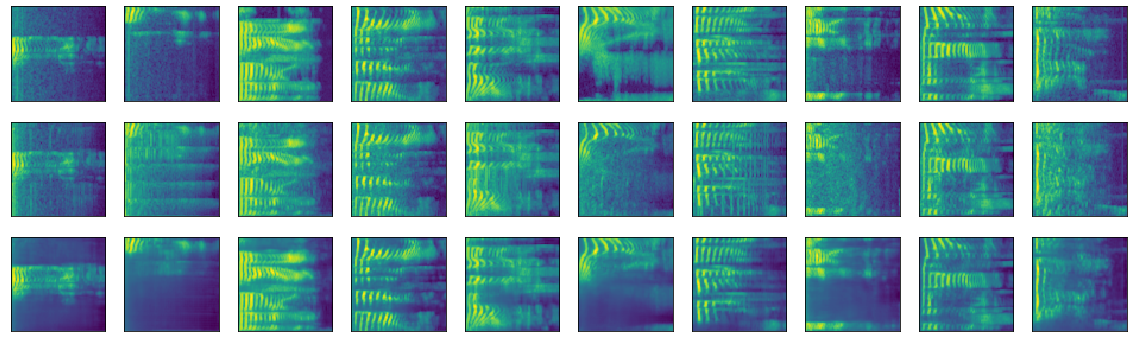

Epoch: 1/50 LR: [0.001]
Train epoch loss:0.0006
val epoch loss:0.0312
Epoch: 2/50 LR: [0.001]
Train epoch loss:0.0005
val epoch loss:0.0299
Epoch: 3/50 LR: [0.001]
Train epoch loss:0.0005
val epoch loss:0.0285
Epoch: 4/50 LR: [0.001]
Train epoch loss:0.0005
val epoch loss:0.0299
EarlyStopping counter: 1 out of 7
Epoch: 5/50 LR: [0.001]
Train epoch loss:0.0005
val epoch loss:0.0279


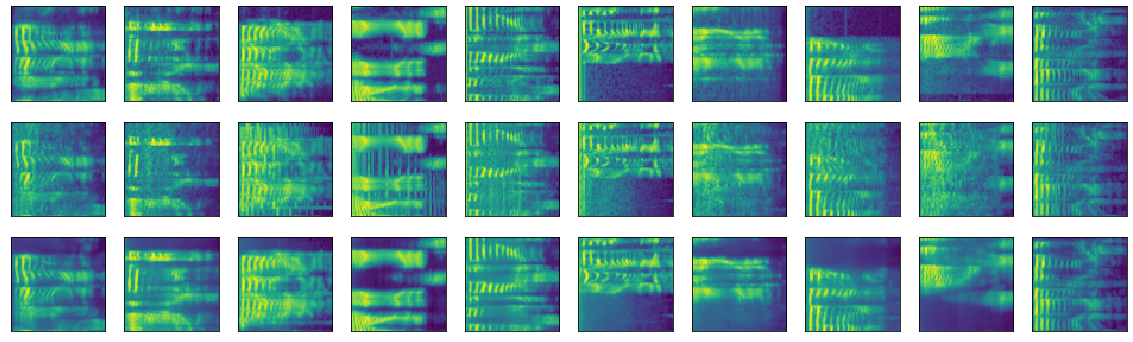

Epoch: 6/50 LR: [0.001]
Train epoch loss:0.0005
val epoch loss:0.0282
EarlyStopping counter: 1 out of 7
Epoch: 7/50 LR: [0.001]
Train epoch loss:0.0005
val epoch loss:0.0281
EarlyStopping counter: 2 out of 7
Epoch: 8/50 LR: [0.001]
Train epoch loss:0.0005
val epoch loss:0.0281
EarlyStopping counter: 3 out of 7
Epoch: 9/50 LR: [0.001]
Train epoch loss:0.0005
val epoch loss:0.0285
EarlyStopping counter: 4 out of 7
Epoch: 10/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0254


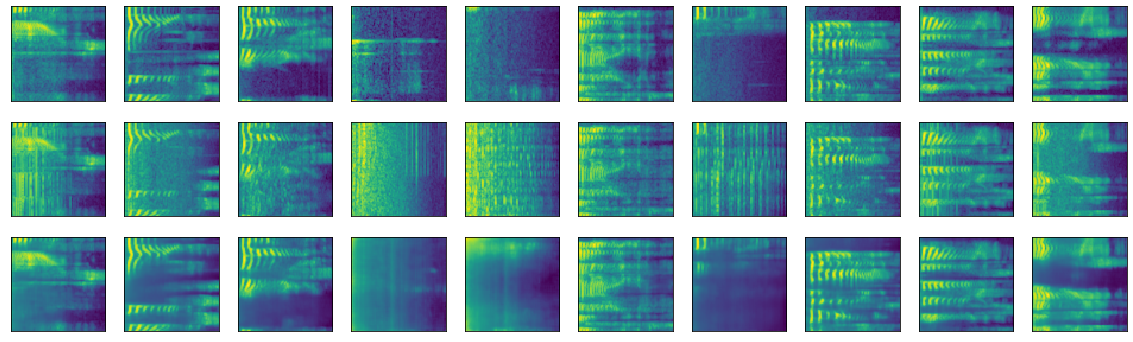

Epoch: 11/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0259
EarlyStopping counter: 1 out of 7
Epoch: 12/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0254
Epoch: 13/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0258
EarlyStopping counter: 1 out of 7
Epoch: 14/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0255
EarlyStopping counter: 2 out of 7
Epoch: 15/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0263
EarlyStopping counter: 3 out of 7


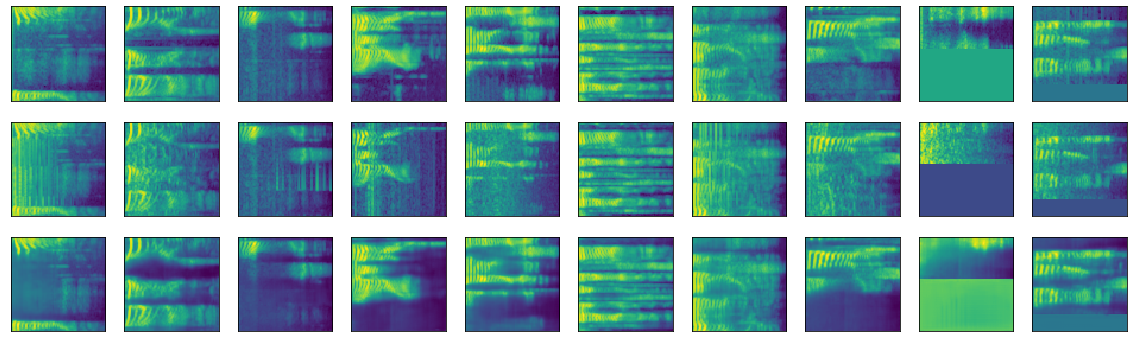

Epoch: 16/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0261
EarlyStopping counter: 4 out of 7
Epoch: 17/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0270
EarlyStopping counter: 5 out of 7
Epoch: 18/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0271
EarlyStopping counter: 6 out of 7
Epoch: 19/50 LR: [0.0001]
Train epoch loss:0.0004
val epoch loss:0.0254
EarlyStopping counter: 7 out of 7
Early stopping


In [17]:
for epoch in range(num_epochs):
    print("Epoch: {}/{}".format(epoch, num_epochs), 'LR:', scheduler.get_lr())
    epoch_loss =0
    count_train =0
    model.train()
    for _, mel_clean, mel_noise in train_loader:
        count_train+=mel_clean.shape[0]
        mel_noise= mel_noise.float()
        mel_clean =mel_clean.float()
        img_noisy = Variable(mel_noise).cuda()
        img_clean = Variable(mel_clean).cuda()
        # ===================forward=====================
        output = model(img_noisy)
        loss = criterion(output, img_clean)
        epoch_loss+=loss.cpu().detach().numpy()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # ===================log========================
    print('Train epoch loss:{:.4f}'.format(epoch_loss/count_train))
    epoch_loss=cross_validation(model,criterion, val_loader,epoch)
    early_stopping(epoch_loss, model)
    scheduler.step()
    
    if early_stopping.early_stop:
        print("Early stopping")
        break
      
    if epoch % 5 == 0:
        plot_frames(img_clean[:10].cpu().detach().numpy(),img_noisy.cpu().detach().numpy(),output.cpu().detach().numpy())
        torch.save(model.state_dict(), 'denoising_autoencoder_01_may.pth')
